In [1]:
import os
# from skimage import exposure
from matplotlib import pyplot as plt
import pandas as pd; pd.options.mode.chained_assignment = None
import numpy as np
import scipy
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from PIL import Image

In [3]:
#LOAD THE NEW TRAIN AND TEST

DATA_DIR = "/kaggle/input/amia-public-challenge-2024/"
TRAIN_DIR = os.path.join(DATA_DIR, "train/train")
TEST_DIR = os.path.join(DATA_DIR, "test/test")


# Capture all the relevant full train/test paths
TRAIN_DICOM_PATHS = [os.path.join(TRAIN_DIR, f_name) for f_name in os.listdir(TRAIN_DIR)]
TEST_DICOM_PATHS = [os.path.join(TEST_DIR, f_name) for f_name in os.listdir(TEST_DIR)]
print(f"\n... The number of training files is {len(TRAIN_DICOM_PATHS)} ...")
print(f"... The number of testing files is {len(TEST_DICOM_PATHS)} ...")

# Define paths to the relevant csv files
TRAIN_CSV = os.path.join(DATA_DIR, "train.csv")
# SS_CSV = os.path.join(DATA_DIR, "sample_submission.csv")

# Create the relevant dataframe objects
train_df = pd.read_csv(TRAIN_CSV)
# ss_df_org = pd.read_csv(SS_CSV)

print("\n\nTRAIN DATAFRAME\n\n")
display(train_df.head(3))


TEST_CSV = os.path.join(DATA_DIR, "test.csv")
# SS_CSV = os.path.join(DATA_DIR, "sample_submission.csv")
# Create the relevant dataframe objects
test_df = pd.read_csv(TEST_CSV)


IMG_SIZE_CSV = os.path.join(DATA_DIR, "img_size.csv")
img_size_df = pd.read_csv(IMG_SIZE_CSV)



... The number of training files is 8573 ...
... The number of testing files is 6427 ...


TRAIN DATAFRAME




,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max
0,bM8C97htulC9fHKIDurJHquCXr1KZuug,No finding,14,R5,NaN,NaN,NaN,NaN
1,0FDQVdLgDKI1sRnPL94LzVh9EvXDVM9m,Aortic enlargement,0,R10,1148.0,503.0,1466.0,823.0
2,Dwk2TnGJFaMhyi3OfCrhdZG9ppGglC5w,Consolidation,4,R8,264.0,732.0,550.0,1119.0


Custom dataset in pytorch

In [4]:
batch_size = 32

In [5]:
'''# Define transformations for the images
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.Grayscale(num_output_channels=3)
])
'''

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(380),  # EfficientNet-B4 utiliza imágenes de 380x380
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3)),
    transforms.Grayscale(num_output_channels=3)
])

test_transform = transforms.Compose([
    transforms.Resize(400),  # Resize to a slightly larger size
    transforms.CenterCrop(380),  # Crop to the expected input size for EfficientNet-B4
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.Grayscale(num_output_channels=3)
])



# Define a custom dataset class
class CustomDataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None, train=True):
        self.dataframe = dataframe
        self.root_dir = root_dir
        self.transform = transform
        self.train = train

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = self.dataframe.iloc[idx, 0] + '.png'  # Assuming images are stored as png files
        img_path = os.path.join(self.root_dir, img_name)
        image = Image.open(img_path)
        #convert to color
        # Convert to RGB if the image is grayscale
        if image.mode != 'RGB':
            image = image.convert('RGB')
        if self.train:
#             if (self.dataframe.iloc[idx, 2]==14):
#                 class_id = 0 # normal
#             else:
#                 class_id = 1 # lesion
            class_id = self.dataframe.iloc[idx, 2]  # Class ID
        else:
            class_id = 0 # we don't know the label for the test.
        if self.transform:
                image = self.transform(image)

        return image, class_id


In [6]:
# Create custom datasets and dataloaders
train_dataset = CustomDataset(dataframe=train_df, root_dir=TRAIN_DIR, train=True, transform=train_transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


In [7]:
test_dataset = CustomDataset(dataframe=test_df, root_dir=TEST_DIR,train=False,transform=test_transform)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size,shuffle=False)

In [25]:
#pip install timm

Note: you may need to restart the kernel to use updated packages.


In [8]:
from timm import create_model

model = create_model('efficientnet_b4', pretrained=True, num_classes=15)


model.safetensors:   0%|          | 0.00/77.9M [00:00<?, ?B/s]

In [9]:
# Define model architecture
#model = models.resnet18(pretrained=True)
#num_ftrs = model.fc.in_features
# model.fc = nn.Linear(num_ftrs, 2)  # Binary classification
#model.fc = nn.Linear(num_ftrs, 15)  # Binary classification


# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 5
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [12]:
'''import gc

def free_gpu_memory():
    """
    Libera la memoria GPU ocupada por PyTorch.
    """
    torch.cuda.empty_cache()
    gc.collect()

# Llamar a la función para liberar memoria GPU
free_gpu_memory()'''

In [10]:
NUM_GPU = torch.cuda.device_count()
print(f"[INFO] number of GPUs found: {NUM_GPU}...")

if NUM_GPU > 1:
    model = nn.DataParallel(model)

[INFO] number of GPUs found: 2...


In [11]:
'''
model.to(device)
model.train()


for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_dataloader, 0):  # Unpack data from dataloader
        inputs, labels = inputs.to(device), labels.to(device)  # Move data to device

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 10 == 9:    # Print every 10 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 10))
            running_loss = 0.0

print('Finished Training')
'''

[1,    10] loss: 2.362
[1,    20] loss: 2.176
[1,    30] loss: 2.117
[1,    40] loss: 2.101
[1,    50] loss: 1.885
[1,    60] loss: 1.978
[1,    70] loss: 1.855
[1,    80] loss: 1.951
[1,    90] loss: 1.974
[1,   100] loss: 1.907
[1,   110] loss: 1.783
[1,   120] loss: 1.861
[1,   130] loss: 1.798
[1,   140] loss: 1.782
[1,   150] loss: 1.838
[1,   160] loss: 1.892
[1,   170] loss: 1.896
[1,   180] loss: 1.825
[1,   190] loss: 1.780
[1,   200] loss: 1.885
[1,   210] loss: 1.681
[1,   220] loss: 1.844
[1,   230] loss: 1.743
[1,   240] loss: 1.763
[1,   250] loss: 1.751
[1,   260] loss: 1.745
[1,   270] loss: 1.701
[1,   280] loss: 1.740
[1,   290] loss: 1.797
[1,   300] loss: 1.778
[1,   310] loss: 1.762
[1,   320] loss: 1.701
[1,   330] loss: 1.578
[1,   340] loss: 1.755
[1,   350] loss: 1.670
[1,   360] loss: 1.700
[1,   370] loss: 1.759
[1,   380] loss: 1.717
[1,   390] loss: 1.616
[1,   400] loss: 1.712
[1,   410] loss: 1.745
[1,   420] loss: 1.791
[1,   430] loss: 1.689
[1,   440] 

In [15]:
'''# Definir criterio y optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Scheduler de learning rate
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Función de entrenamiento
def train_model(model, criterion, optimizer, scheduler, num_epochs=15):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        # Evaluar en el conjunto de validación
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in test_dataloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {running_loss/len(train_loader)}, Val Loss: {val_loss/len(val_loader)}, Val Accuracy: {correct/total}')

        # Actualizar el scheduler
        scheduler.step()

    print('Finished Training')

# Entrenar el modelo
train_model(model, criterion, optimizer, scheduler, num_epochs=5)'''

"# Definir criterio y optimizador\ncriterion = nn.CrossEntropyLoss()\noptimizer = optim.Adam(model.parameters(), lr=0.001)\n\n# Scheduler de learning rate\nscheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)\n\n# Función de entrenamiento\ndef train_model(model, criterion, optimizer, scheduler, num_epochs=15):\n    for epoch in range(num_epochs):\n        model.train()\n        running_loss = 0.0\n        for inputs, labels in train_dataloader:\n            inputs, labels = inputs.to(device), labels.to(device)\n            optimizer.zero_grad()\n            outputs = model(inputs)\n            loss = criterion(outputs, labels)\n            loss.backward()\n            optimizer.step()\n            running_loss += loss.item()\n        \n        # Evaluar en el conjunto de validación\n        model.eval()\n        val_loss = 0.0\n        correct = 0\n        total = 0\n        with torch.no_grad():\n            for inputs, labels in test_dataloader:\n                i

In [12]:
#torch.save(model.state_dict(), 'amia-effinetb4_32batch_5epochs_dataaugmentation_380p_testcrop_inference.pth')

In [13]:
#torch.save(model,'amia-effinetb4_32batch_5epochs-dataaugmentation-380p-model.pth')

In [13]:
print(len(test_dataloader))
print(len(train_dataloader))

344
718


In [14]:
#### paste pth file!  #### 

model.load_state_dict(torch.load("/kaggle/input/effinet-b4/pytorch/v1/1/amia-effinetb4_32batch_5epochs_dataaugmentation_380p_testcrop_inference.pth"))

<All keys matched successfully>

In [15]:
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
import torch.nn.functional as F
# Inference on the test dataset
model.eval()
test_predictions = []
test_probabilities = []
with torch.no_grad():
    for i, data in enumerate (test_dataloader):
        print("doing batch",i)
        # Unpack the data batch
        inputs, _ = data  # Assuming data is a tuple (images, labels)

        # Move inputs to the device
        inputs = inputs.to(device)

        # Move model to the same device as inputs
        model = model.to(device)

        # Perform inference
        outputs = model(inputs)

        # Get predictions
        _, predicted = torch.max(outputs, 1)

        # Get class probabilities
        probabilities,_ = torch.max(F.softmax(outputs, dim=1),1)

        # Convert tensors to CPU numpy arrays
        test_predictions.extend(predicted.cpu().numpy())
        test_probabilities.extend(probabilities.cpu().numpy())
#         print (test_probabilities)
# Assuming you want to add predictions to the test dataframe
test_df['predicted_class'] = test_predictions
test_df['probabilities'] = test_probabilities
print(test_df.head())


doing batch 0
doing batch 1
doing batch 2
doing batch 3
doing batch 4
doing batch 5
doing batch 6
doing batch 7
doing batch 8
doing batch 9
doing batch 10
doing batch 11
doing batch 12
doing batch 13
doing batch 14
doing batch 15


In [17]:
## ?? @

test_df['Prob']  = test_df['probabilities'].max()
    
test_df

,image_id,predicted_class,probabilities,Prob
0,3r9OdPSdvQ58qI3VUFUeSKyCvxBpFc0c,13,0.339730,1.0
1,LO2jAm8E96Ih87wJVoqiOXHixrwPMeOm,14,1.000000,1.0
2,PN7S4HbhNp4fht9TTc6DXGOKGkeRTR7W,14,1.000000,1.0
3,l7f2KDvrnrh26v4aYgi0Slj7lVBZMQIL,14,1.000000,1.0
4,if5Pqu95xLUtURzAo72YiSg8GNzJb1F3,14,1.000000,1.0
...,...,...,...,...
21984,k576EmhRJuLOIBHFyzH7LRcr2JbYFnHM,14,1.000000,1.0
21985,yFiQoOEOTP6yO3KMmiAQ5zkBjdww7icn,14,0.999976,1.0
21986,yg7B1t1DO9tMk2uJV0SkqA82y97SPZHa,14,1.000000,1.0
21987,1oO2FHrNonZqP9i854X6sio2hZj4R4h0,5,0.348019,1.0


In [18]:
test_df.to_csv('test_predictions.csv', index=False)

In [ ]:
# # Function to get the maximum value from a list
# def get_max_value(lst):
#     return max(lst)

# # Apply the function to the vector column to get the maximum value
# test_df['Prob'] = test_df['probabilities'].apply(get_max_value)

# print(test_df)

                               image_id  predicted_class  \

0      3r9OdPSdvQ58qI3VUFUeSKyCvxBpFc0c                1   

1      LO2jAm8E96Ih87wJVoqiOXHixrwPMeOm                0   

2      PN7S4HbhNp4fht9TTc6DXGOKGkeRTR7W                0   

3      l7f2KDvrnrh26v4aYgi0Slj7lVBZMQIL                1   

4      if5Pqu95xLUtURzAo72YiSg8GNzJb1F3                0   

...                                 ...              ...   

21984  k576EmhRJuLOIBHFyzH7LRcr2JbYFnHM                0   

21985  yFiQoOEOTP6yO3KMmiAQ5zkBjdww7icn                1   

21986  yg7B1t1DO9tMk2uJV0SkqA82y97SPZHa                0   

21987  1oO2FHrNonZqP9i854X6sio2hZj4R4h0                1   

21988  8Q8fPobVc11InzzHAKDfjH2emkfnEdnC                0   



                     probabilities      Prob  

0      [2.0238736e-05, 0.99997973]  0.999980  

1      [0.99999726, 2.7123774e-06]  0.999997  

2       [0.9998671, 0.00013289662]  0.999867  

3        [0.056354914, 0.94364506]  0.943645  

4         [0.9955727, 0.00

# Batch size = 256

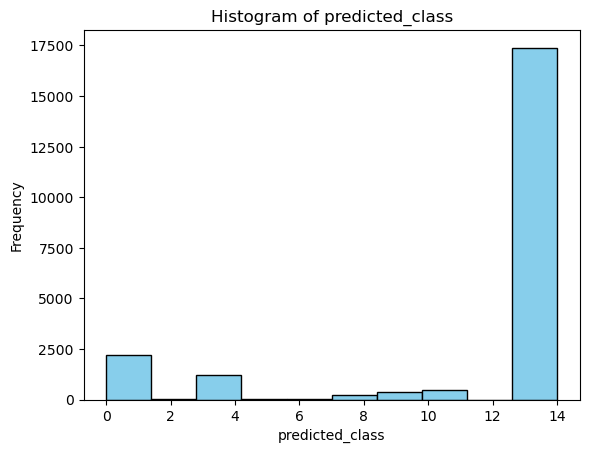

In [ ]:
'''# Specify the column name for which you want to plot the histogram
column_name = 'predicted_class'

# Plot the histogram
plt.hist(test_df[column_name], bins=10, color='skyblue', edgecolor='black')

# Add labels and title
plt.xlabel(column_name)
plt.ylabel('Frequency')
plt.title('Histogram of ' + column_name)

# Show the plot
plt.show()
'''

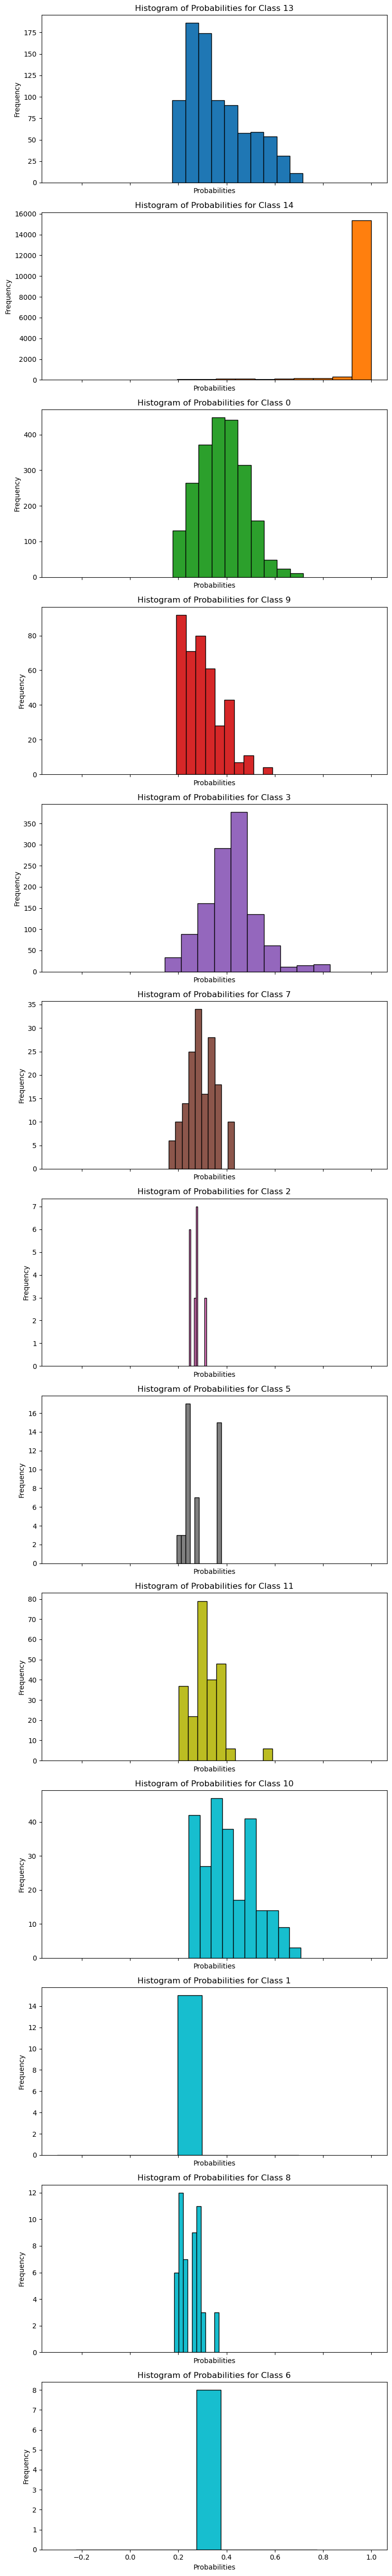

In [ ]:
'''# Get unique class labels
classes = test_df['predicted_class'].unique()

# Create subplots for each class
fig, axs = plt.subplots(len(classes), 1, figsize=(8, len(classes)*4), sharex=True)

# Define a colormap
cmap = plt.cm.get_cmap('tab10')

# Plot histograms for each class
for i, cls in enumerate(classes):
    # Filter data for the current class
    data = test_df[test_df['predicted_class'] == cls]['probabilities']
    # Plot histogram with a unique color for each class
    axs[i].hist(data, bins=10, color=cmap(i), edgecolor='black')

    # Add labels and title
    axs[i].set_xlabel('Probabilities')
    axs[i].set_ylabel('Frequency')
    axs[i].set_title('Histogram of Probabilities for Class {}'.format(cls))

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()'''

# Batch size = 128

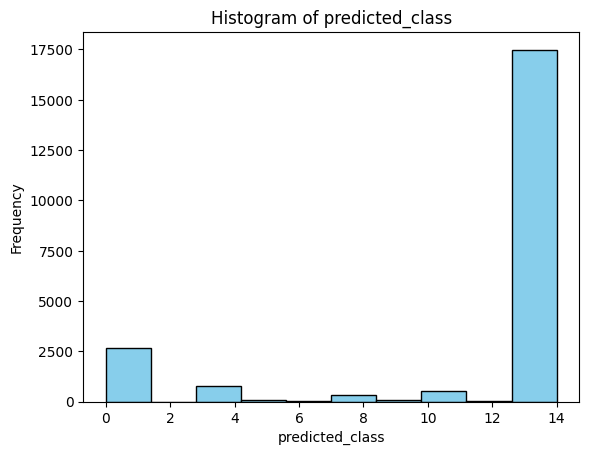

In [17]:
'''# Specify the column name for which you want to plot the histogram
column_name = 'predicted_class'

# Plot the histogram
plt.hist(test_df[column_name], bins=10, color='skyblue', edgecolor='black')

# Add labels and title
plt.xlabel(column_name)
plt.ylabel('Frequency')
plt.title('Histogram of ' + column_name)

# Show the plot
plt.show()'''

/tmp/ipykernel_34/1409017762.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab10')


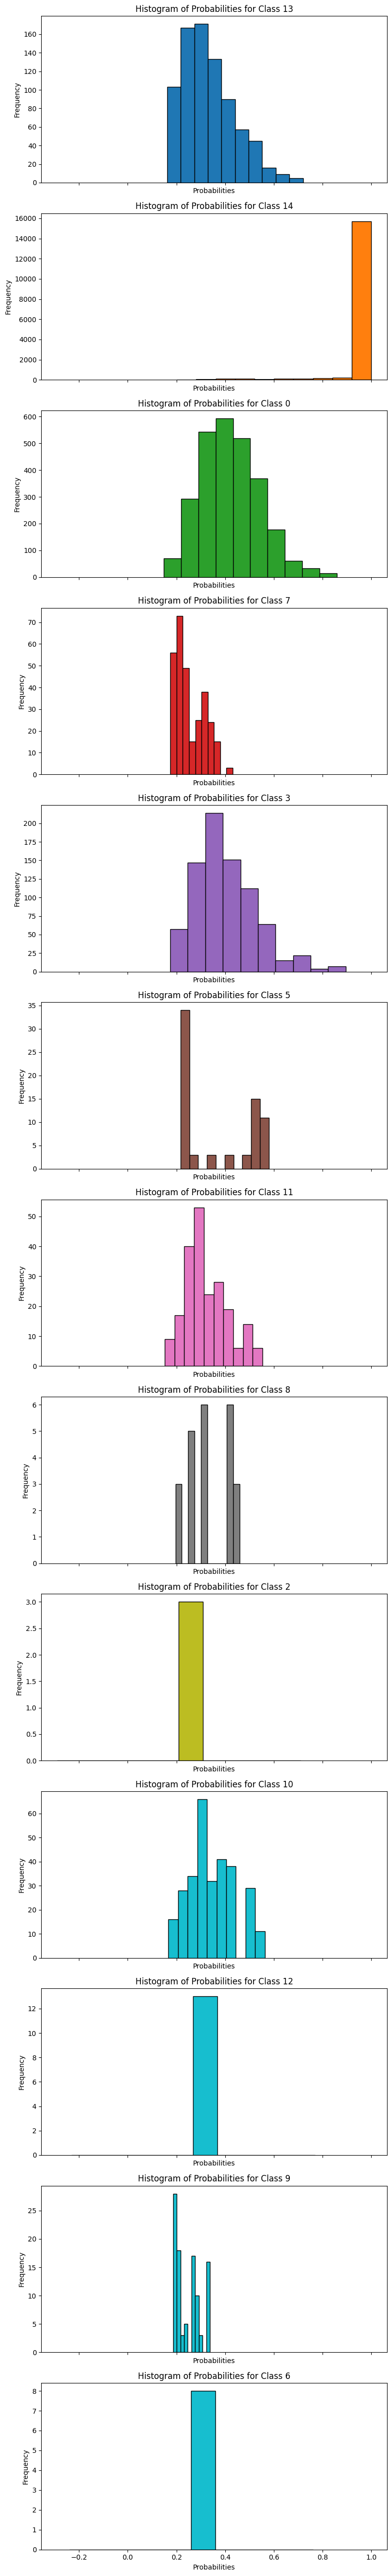

In [18]:
'''# Specify the column name for which you want to plot the histogram
column_name = 'predicted_class'

# Plot the histogram
plt.hist(test_df[column_name], bins=10, color='skyblue', edgecolor='black')

# Add labels and title
plt.xlabel(column_name)
plt.ylabel('Frequency')
plt.title('Histogram of ' + column_name)

# Show the plot
plt.show()


# Get unique class labels
classes = test_df['predicted_class'].unique()

# Create subplots for each class
fig, axs = plt.subplots(len(classes), 1, figsize=(8, len(classes)*4), sharex=True)

# Define a colormap
cmap = plt.cm.get_cmap('tab10')

# Plot histograms for each class
for i, cls in enumerate(classes):
    # Filter data for the current class
    data = test_df[test_df['predicted_class'] == cls]['probabilities']
    # Plot histogram with a unique color for each class
    axs[i].hist(data, bins=10, color=cmap(i), edgecolor='black')

    # Add labels and title
    axs[i].set_xlabel('Probabilities')
    axs[i].set_ylabel('Frequency')
    axs[i].set_title('Histogram of Probabilities for Class {}'.format(cls))

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()'''

# Batch size 64 (15 epochs)

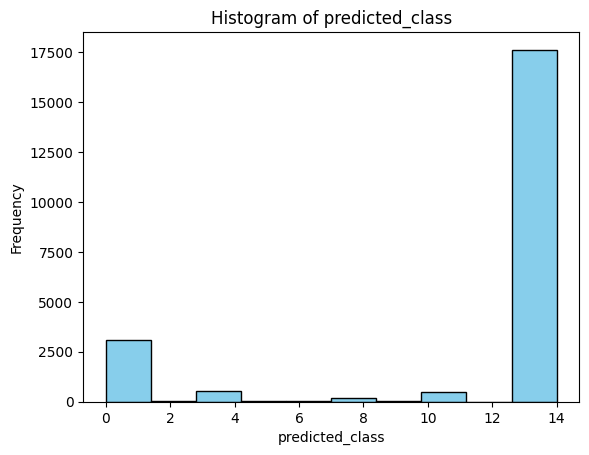

/tmp/ipykernel_34/2383262437.py:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab10')


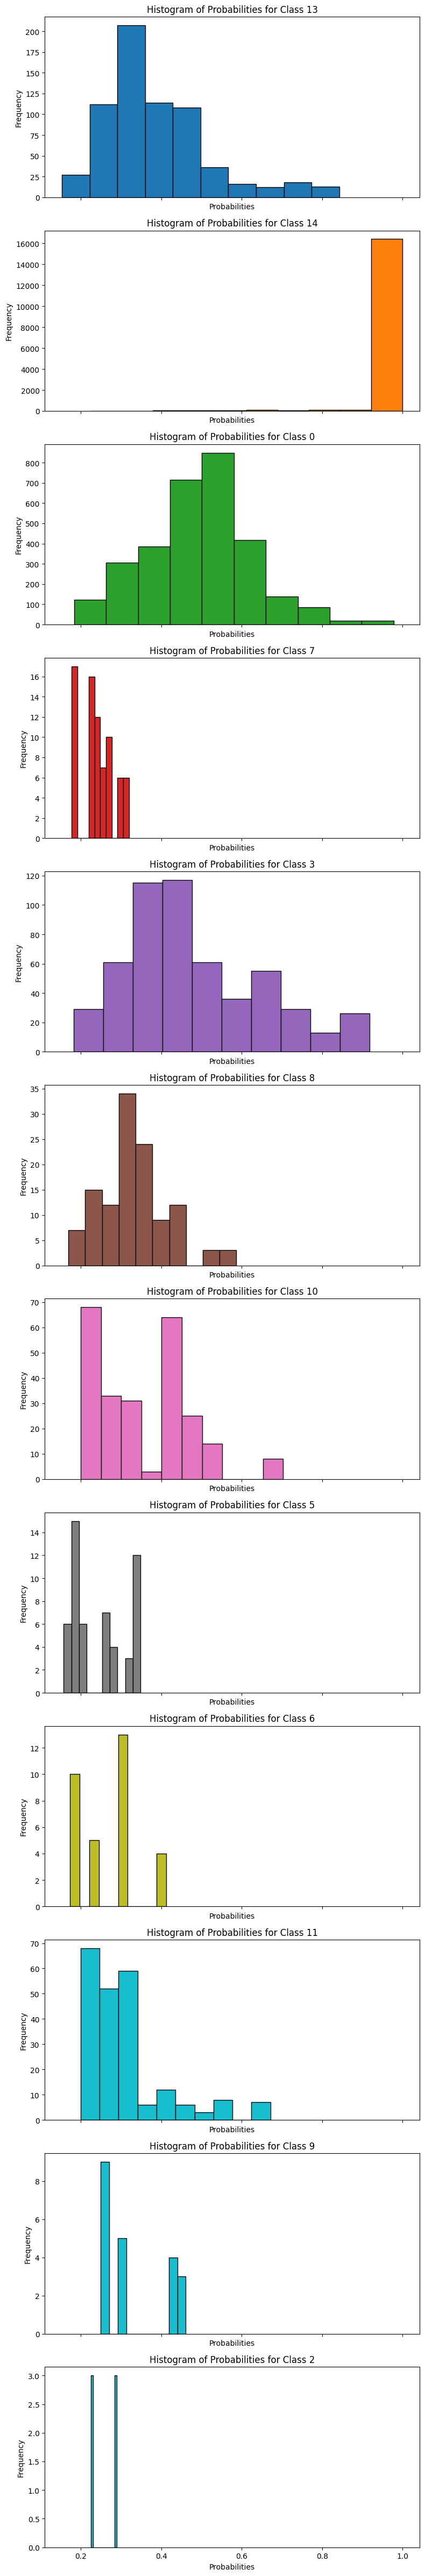

In [19]:
# Specify the column name for which you want to plot the histogram
column_name = 'predicted_class'

# Plot the histogram
plt.hist(test_df[column_name], bins=10, color='skyblue', edgecolor='black')

# Add labels and title
plt.xlabel(column_name)
plt.ylabel('Frequency')
plt.title('Histogram of ' + column_name)

# Show the plot
plt.show()


# Get unique class labels
classes = test_df['predicted_class'].unique()

# Create subplots for each class
fig, axs = plt.subplots(len(classes), 1, figsize=(8, len(classes)*4), sharex=True)

# Define a colormap
cmap = plt.cm.get_cmap('tab10')

# Plot histograms for each class
for i, cls in enumerate(classes):
    # Filter data for the current class
    data = test_df[test_df['predicted_class'] == cls]['probabilities']
    # Plot histogram with a unique color for each class
    axs[i].hist(data, bins=10, color=cmap(i), edgecolor='black')

    # Add labels and title
    axs[i].set_xlabel('Probabilities')
    axs[i].set_ylabel('Frequency')
    axs[i].set_title('Histogram of Probabilities for Class {}'.format(cls))

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

In [34]:
test_df

,image_id,predicted_class,probabilities,Prob
0,3r9OdPSdvQ58qI3VUFUeSKyCvxBpFc0c,13,0.212246,1.0
1,LO2jAm8E96Ih87wJVoqiOXHixrwPMeOm,14,1.000000,1.0
2,PN7S4HbhNp4fht9TTc6DXGOKGkeRTR7W,14,1.000000,1.0
3,l7f2KDvrnrh26v4aYgi0Slj7lVBZMQIL,14,0.971445,1.0
4,if5Pqu95xLUtURzAo72YiSg8GNzJb1F3,14,0.999998,1.0
...,...,...,...,...
21984,k576EmhRJuLOIBHFyzH7LRcr2JbYFnHM,14,0.999999,1.0
21985,yFiQoOEOTP6yO3KMmiAQ5zkBjdww7icn,14,0.985826,1.0
21986,yg7B1t1DO9tMk2uJV0SkqA82y97SPZHa,14,1.000000,1.0
21987,1oO2FHrNonZqP9i854X6sio2hZj4R4h0,14,0.429380,1.0


In [20]:
#test_df = pd.read_csv('test_predictions.csv')
#test_df.head()

# change 0 for 14
# change 1 for 0
test_df['predicted_class'] = test_df['predicted_class'].replace(0, 14)
test_df['predicted_class'] = test_df['predicted_class'].replace(1, 0)

def prepare_pred(row):
    prob = str(row['probabilities']) if not pd.isna(row['probabilities']) else '0'  # Convert NaN to '0'
    if row['predicted_class'] == 14: 
        return '14 ' + prob + ' 0 0 1 1'
    else:
        return str(row['predicted_class']) + ' ' + prob + ' 700 700 1000 1000'
    
# Apply the function to add text to specific rows
test_df['PredictionString'] = test_df.apply(prepare_pred, axis=1)

# # Create a new column by concatenating 'predicted_class' and 'Prob' as strings
# test_df['PredictionString'] = test_df['predicted_class'].astype(str) + ' ' + test_df['Prob'].astype(str) + ' 0 0 1 1'

# Create a new DataFrame with 'image_id' and 'new_column'
test_df_submit = test_df[['image_id', 'PredictionString']]

print(test_df_submit)

test_df_submit = test_df_submit.drop_duplicates()
# duplicate_rows = test_df_submit[test_df_submit.duplicated()]

# if duplicate_rows.empty:
#     print("No duplicate rows found.")
# else:
#     print("Duplicate rows found:")
#     print(duplicate_rows)
test_df_submit.to_csv('submission.csv', index=False)
print(test_df_submit)

                               image_id  \
0      3r9OdPSdvQ58qI3VUFUeSKyCvxBpFc0c   
1      LO2jAm8E96Ih87wJVoqiOXHixrwPMeOm   
2      PN7S4HbhNp4fht9TTc6DXGOKGkeRTR7W   
3      l7f2KDvrnrh26v4aYgi0Slj7lVBZMQIL   
4      if5Pqu95xLUtURzAo72YiSg8GNzJb1F3   
...                                 ...   
21984  k576EmhRJuLOIBHFyzH7LRcr2JbYFnHM   
21985  yFiQoOEOTP6yO3KMmiAQ5zkBjdww7icn   
21986  yg7B1t1DO9tMk2uJV0SkqA82y97SPZHa   
21987  1oO2FHrNonZqP9i854X6sio2hZj4R4h0   
21988  8Q8fPobVc11InzzHAKDfjH2emkfnEdnC   

                              PredictionString  
0      13 0.3397303819656372 700 700 1000 1000  
1                               14 1.0 0 0 1 1  
2                               14 1.0 0 0 1 1  
3                               14 1.0 0 0 1 1  
4                               14 1.0 0 0 1 1  
...                                        ...  
21984                           14 1.0 0 0 1 1  
21985            14 0.9999759197235107 0 0 1 1  
21986                           14 1.0 0 0

In [39]:
'''test_df = pd.read_csv('test_predictions.csv')
test_df.head()

# change 0 for 14
# change 1 for 0
test_df['predicted_class'] = test_df['predicted_class'].replace(0, 14)
test_df['predicted_class'] = test_df['predicted_class'].replace(1, 0)

def prepare_pred(row):
    prob = str(row['probabilities']) if not pd.isna(row['probabilities']) else '0'  # Convert NaN to '0'
    if row['predicted_class'] == 14: 
        return '14 ' + prob + ' 0 0 1 1'
    else:
        return str(row['predicted_class']) + ' ' + prob + ' 700 700 1000 1000'
    
# Apply the function to add text to specific rows
test_df['PredictionString'] = test_df.apply(prepare_pred, axis=1)

# # Create a new column by concatenating 'predicted_class' and 'Prob' as strings
# test_df['PredictionString'] = test_df['predicted_class'].astype(str) + ' ' + test_df['Prob'].astype(str) + ' 0 0 1 1'

# Create a new DataFrame with 'image_id' and 'new_column'
test_df_submit = test_df[['image_id', 'PredictionString']]

print(test_df_submit)

test_df_submit = test_df_submit.drop_duplicates()
# duplicate_rows = test_df_submit[test_df_submit.duplicated()]

# if duplicate_rows.empty:
#     print("No duplicate rows found.")
# else:
#     print("Duplicate rows found:")
#     print(duplicate_rows)
#test_df_submit.to_csv('submission.csv', index=False)
print(test_df_submit)'''

                               image_id                 PredictionString
0      3r9OdPSdvQ58qI3VUFUeSKyCvxBpFc0c  13 0.21224615 700 700 1000 1000
1      LO2jAm8E96Ih87wJVoqiOXHixrwPMeOm                   14 1.0 0 0 1 1
2      PN7S4HbhNp4fht9TTc6DXGOKGkeRTR7W                   14 1.0 0 0 1 1
3      l7f2KDvrnrh26v4aYgi0Slj7lVBZMQIL            14 0.97144544 0 0 1 1
4      if5Pqu95xLUtURzAo72YiSg8GNzJb1F3             14 0.9999976 0 0 1 1
...                                 ...                              ...
21984  k576EmhRJuLOIBHFyzH7LRcr2JbYFnHM            14 0.99999917 0 0 1 1
21985  yFiQoOEOTP6yO3KMmiAQ5zkBjdww7icn             14 0.9858255 0 0 1 1
21986  yg7B1t1DO9tMk2uJV0SkqA82y97SPZHa                   14 1.0 0 0 1 1
21987  1oO2FHrNonZqP9i854X6sio2hZj4R4h0            14 0.42938027 0 0 1 1
21988  8Q8fPobVc11InzzHAKDfjH2emkfnEdnC                   14 1.0 0 0 1 1

[21989 rows x 2 columns]
                               image_id                 PredictionString
0      3r9OdPSdvQ58qI3VUF

In [21]:
test_df_submit

,image_id,PredictionString
0,3r9OdPSdvQ58qI3VUFUeSKyCvxBpFc0c,13 0.3397303819656372 700 700 1000 1000
1,LO2jAm8E96Ih87wJVoqiOXHixrwPMeOm,14 1.0 0 0 1 1
2,PN7S4HbhNp4fht9TTc6DXGOKGkeRTR7W,14 1.0 0 0 1 1
3,l7f2KDvrnrh26v4aYgi0Slj7lVBZMQIL,14 1.0 0 0 1 1
4,if5Pqu95xLUtURzAo72YiSg8GNzJb1F3,14 1.0 0 0 1 1
...,...,...
21958,mQn44K3rB0ZhYB4JNr6D4ShJH1muPfru,14 0.5909140110015869 0 0 1 1
21960,JrF9N2uclj7mjDSoYNhSpHRTs2Gvp4F6,13 0.24556884169578552 700 700 1000 1000
21961,mYaPP4VMxZMfiTy1SNiCfVdMNRo2PMs1,3 0.42137107253074646 700 700 1000 1000
21971,vFnijVxxYfJ2wVKpYmuD9Qf59sUdM64H,8 0.41507431864738464 700 700 1000 1000


In [22]:
duplicate_rows = test_df_submit[test_df_submit.duplicated(subset=['image_id'])]

if duplicate_rows.empty:
    print("No se encontraron filas duplicadas.")
else:
    print("Filas duplicadas encontradas:")
    print(duplicate_rows)

Filas duplicadas encontradas:
                               image_id  \
21952  hAYgngereHhR5mGYqArPg11abCs8Hu0K   
21955  ZsODKXE4hTfXmAnCKJPh7j2NfnOTu0th   
21956  rTGArHtFtSEfznfZUW6yuPHxWl1S6u0g   
21957  8izGxiycXhrtm07MNYi5R5W5q3ODWvYW   
21958  mQn44K3rB0ZhYB4JNr6D4ShJH1muPfru   
21960  JrF9N2uclj7mjDSoYNhSpHRTs2Gvp4F6   
21961  mYaPP4VMxZMfiTy1SNiCfVdMNRo2PMs1   
21971  vFnijVxxYfJ2wVKpYmuD9Qf59sUdM64H   
21987  1oO2FHrNonZqP9i854X6sio2hZj4R4h0   

                               PredictionString  
21952             14 0.7551624178886414 0 0 1 1  
21955             14 0.5370842218399048 0 0 1 1  
21956            14 0.29054901003837585 0 0 1 1  
21957  11 0.32095614075660706 700 700 1000 1000  
21958             14 0.5909140110015869 0 0 1 1  
21960  13 0.24556884169578552 700 700 1000 1000  
21961   3 0.42137107253074646 700 700 1000 1000  
21971   8 0.41507431864738464 700 700 1000 1000  
21987    5 0.3480185270309448 700 700 1000 1000  


In [23]:
test_df_submit = test_df_submit.drop_duplicates(subset=['image_id'])

duplicate_rows = test_df_submit[test_df_submit.duplicated(subset=['image_id'])]

if duplicate_rows.empty:
    print("No se encontraron filas duplicadas.")
else:
    print("Filas duplicadas encontradas:")
    print(duplicate_rows)

No se encontraron filas duplicadas.


In [24]:
test_df_submit.to_csv('submission.csv', index=False)

In [38]:
#batch size 256

'''print(test_df.describe())
# Save the DataFrame to a CSV file
test_df.to_csv('test_predictions.csv', index=False)'''

       predicted_class  probabilities     Prob
count     21989.000000   21989.000000  21989.0
mean         13.324890       0.834743      1.0
std           2.318046       0.274033      0.0
min           2.000000       0.148005      1.0
25%          14.000000       0.620454      1.0
50%          14.000000       0.999998      1.0
75%          14.000000       1.000000      1.0
max          14.000000       1.000000      1.0


In [ ]:
#batch size 128

print(test_df.describe())
# Save the DataFrame to a CSV file
test_df.to_csv('test_predictions.csv', index=False)

       predicted_class          Prob

count     21989.000000  21989.000000

mean          9.560417      0.967361

std           6.515075      0.088804

min           0.000000      0.501167

25%           0.000000      0.992792

50%          14.000000      0.999810

75%          14.000000      0.999995

max          14.000000      1.000000
